# Source Detection

This notebook shows an end to end radio interferometry pipeline from the sky to final image using the Karabo pipeline. In addition, we show you how to get the pixel coordinates of the point sources of the produced image. The simulation of the sky, telescope and observation are based on [OSKAR](https://ska-telescope.gitlab.io/sim/oskar/), the imaging on [RASCIL](https://ska-telescope.gitlab.io/external/rascil/index.html).

For this example we use the GLEAM survey [GLEAM EGC catalog version 2](https://vizier.cds.unistra.fr/viz-bin/VizieR-3), which can be downloaded from the [VizieR](https://cdsarc.unistra.fr/viz-bin/cat/VIII/100) service. To download the full survey, you have to change **preferences/max** to unlimited. The download here was done using the **FITS (binary) Table** option which can be selected in the dropdown menu below. The GLEAM survey was created using the Murchison Widefield Array (MWA), the low-frequency Square Kilometre Array (SKA1 LOW) precursor located in western Australia. The catalogue covers 24,402 square degrees, over declinations south of +30° and galactic latitudes outside 10° of the galactic plane, excluding some areas such as the Magellanic clouds. It contains 307,456 radio sources with 20 separate flux density measurements across 72-231 MHz, selected from a time- and frequency- integrated image centred at 200 MHz, with a resolution of ~=2'.

In [1]:
from datetime import datetime, timedelta

from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.sourcedetection.result import SourceDetectionResult
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation

# Render plots inline
%matplotlib inline

## Sky Catalog

Of course, any catalog downloaded in any format such as .fits or .csv can be used. Since the structures of the catalogs can differ significantly, we leave the preprocessing to the format of the `SkyModel` (from `karabo.simulation.sky_model`) to the user. The `SkyModel` has the following catalog format:

- right_ascension:
- declination:
- stokes_I_flux:
- stokes_Q_flux:
- stokes_U_flux:
- stokes_V_flux:
- reference_frequency:
- spectral_index:
- rotation_measure:
- major_axis_FWHM:
- minor_axis_FWHM:
- position_angle:
- source_id:

For this example we only use right ascension (RAJ2000) and declination (DEJ2000) and the Stokes I peak flux intensity at 76 MHz (Fp076). There are some sources which have no flux values in the corresponding frequency band. These must be removed first.

In [2]:
sky = SkyModel.get_GLEAM_Sky()
sky

In [3]:
sky.num_sources

307087

Before further steps are taken, the phase center of the telescope must be defined.

In [4]:
phase_center = [250, -80]  # ra,dec

Now we just look at the Log10 Stokes I flux of the GLEAM survey. This provides a better overview of how the survey looks like on the sphere.

/home/vincenzo/Karabo-Pipeline/karabo/simulation/sky_model.py:422: RuntimeWarning: invalid value encountered in log10
  log_flux = np.log10(flux)


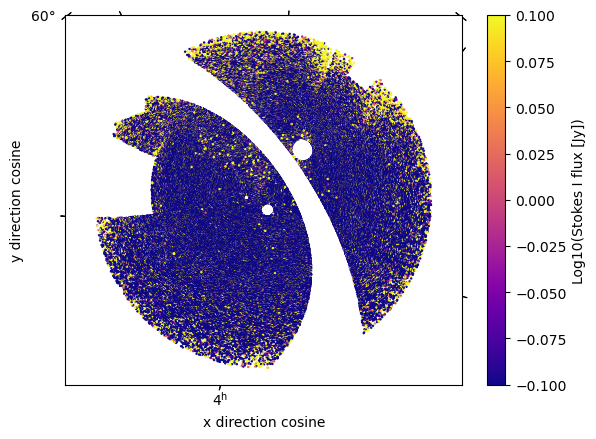

In [5]:
sky.plot_sky(phase_center)

Now that we have determined the phase center we can take a closer look at how the point sources are distributed around the center. For this we use a coordinate 2d image projection with the phase center as the origin using the the world coordinate system ([wcs](https://docs.astropy.org/en/stable/wcs/index.html)) of astropy. Specific information about the wcs parameters can be found [here](https://docs.astropy.org/en/stable/api/astropy.wcs.Wcsprm.html). For this illustration, we take the Stokes I flux intensity into account to address for it's brightness. The value conversion is done using a function which is defined in the argument `cfun` of `explore_sky`. Here we uses np.log10 as default. If you wish to not have the intensity colored just set `cfun=None`.

Important here is that `explore_sky` sets up a default `wcs` if none is set. So if you want to have a specific `wcs` for the `SkyModel` you have to set it prior or afterwards yourself.

/home/vincenzo/Karabo-Pipeline/karabo/simulation/sky_model.py:389: RuntimeWarning: invalid value encountered in log10
  flux = cfun(flux)


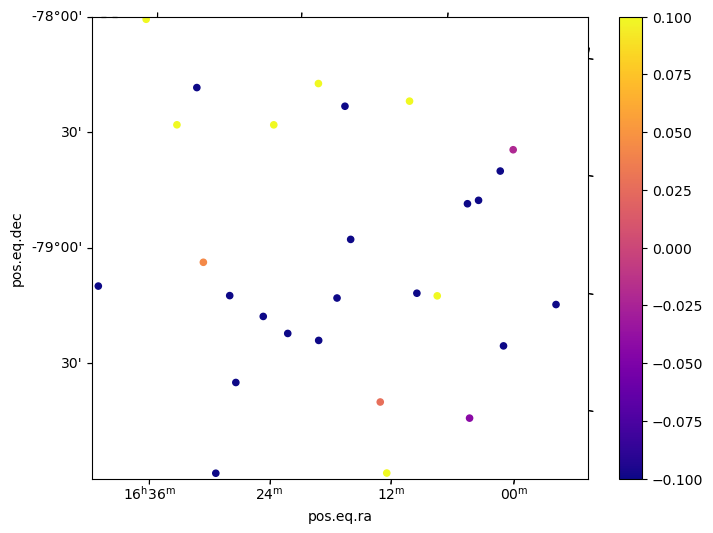

In [6]:
sky.explore_sky(phase_center=phase_center, figsize=(8, 6))

Now, to have only a partition of the sky, we can use the `filter_by_radius`, which filters from the phase center with an inner and outer radius in degrees. We provide an additional filter `filter_by_flux` which filters the sky using the Stokes I flux and `filter_by_frequency` which filters the sky using the reference frequency. In addition, we set the world coordinate system `astropy.wcs` using `setup_default_wcs` at the `phase_center`. The wcs is later needed for coordinate transformation when the imaging parameters are known.

In [7]:
# first filter sky by inner and outer radius in degrees from the phase center
filtered_sky = sky.filter_by_radius(0, .55, phase_center[0], phase_center[1])
filtered_sky.setup_default_wcs(phase_center)
filtered_sky.num_sources

8

Now let's look at the filtered sources.

/home/vincenzo/Karabo-Pipeline/karabo/simulation/sky_model.py:389: RuntimeWarning: invalid value encountered in log10
  flux = cfun(flux)


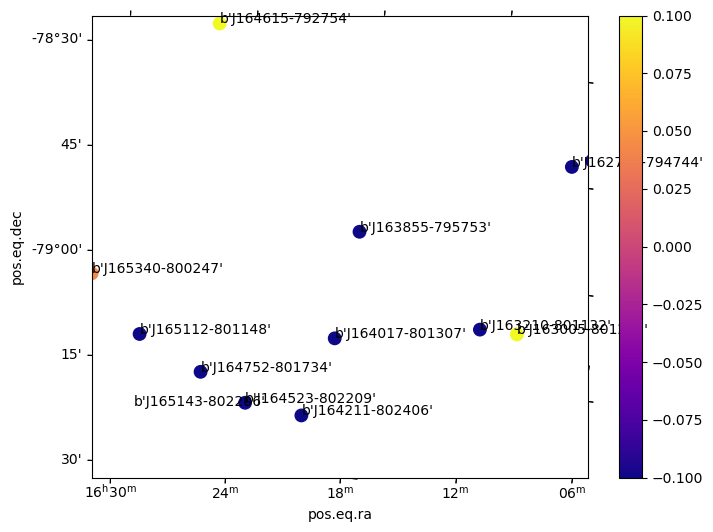

In [8]:
sky.explore_sky(phase_center=phase_center, figsize=(8, 6), s=80,
                xlim=(-.55, .55), ylim=(-.55, .55), with_labels=True)

### Telescope & Observation Module

Now that we have filtered the sky and set the phase center, we define and simulate the telescope and the observation. With `get_OSKAR_Example_Telescope` we get a `Telescope` object (from `karabo.simulation.telescope`) consisting of an interferometer with 30 aperture array stations, each with 2587 antenna elements.

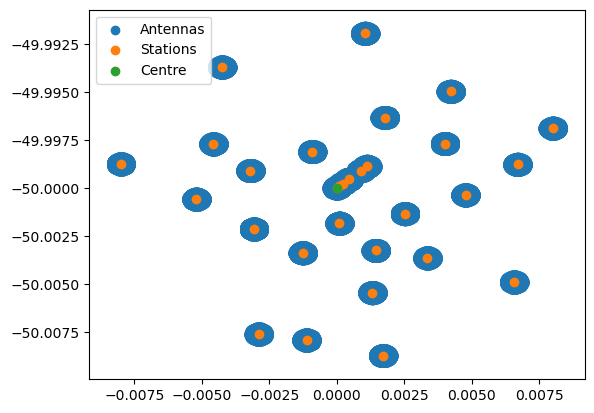

In [9]:
telescope = Telescope.get_OSKAR_Example_Telescope()
telescope.plot_telescope()

Then we define an `observation` (from `karabo.simulation.observation`) where the observation parameters are defined.

In [10]:
observation = Observation(start_frequency_hz=100e6, start_date_and_time=datetime(2000, 1, 1, 12, 0),
                          length=timedelta(hours=12), number_of_channels=16, frequency_increment_hz=20e6,
                          phase_centre_ra_deg=phase_center[0], phase_centre_dec_deg=phase_center[1],
                          number_of_time_steps=24)

Now we set simulation parameters using `InterferometerSimulation` (from `karabo.simulation.intererometer`) in the constructor and start the simulation using `run_simulation`.

In [11]:
interferometer = InterferometerSimulation(channel_bandwidth_hz=1e6, time_average_sec=10)

In [12]:
simulated_sky = interferometer.run_simulation(telescope, filtered_sky, observation)

W|                                                                   
W|== WARNING: No GPU capability available.
W|                                                                   


### Imaging

Now we start the imaging process using the `Imager` (from `karabo.simulation.imager`) with the visibilities in 'simulated_sky'. The `Imager` allows various configurations concerning imaging, calibration, Clean and Dask. Important for source detection is `imaging_npixel` which defines the number of pixels in x,y rsp. ra,dec direction and `imaging_cellsize` which defines the coverage of a pixel in radian. In this example the image covers $3.878509448876288\times 10^{-5} * 2048 * 180 / \pi \approx 4.55°$ degrees, so $4.55/2 = 2.28°$ degrees in each direction from the phase center.

In [13]:
from karabo.imaging.imager import Imager

cell_size = 3.878509448876288e-05*2
npixel = 2048

imager = Imager(simulated_sky,
                ingest_dd=[0],
                ingest_vis_nchan=16,
                ingest_chan_per_blockvis=1,
                ingest_average_blockvis=True,
                imaging_npixel=npixel,
                imaging_cellsize=cell_size,
                imaging_weighting='robust',
                imaging_robustness=-.5)

result = imager.imaging_rascil(
    clean_nmajor=0,
    clean_algorithm='mmclean',
    clean_scales=[0, 6, 10, 30, 60],
    clean_fractional_threshold=.3,
    clean_threshold=.12e-3,
    clean_nmoment=5,
    clean_psf_support=640,
    clean_restored_output='integrated')

/home/vincenzo/miniconda3/envs/karabo_dev_env/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40119 instead
  warnings.warn(


Client Dashboard Address: http://127.0.0.1:40119/status
LocalCluster(128d5cad, 'tcp://127.0.0.1:43683', workers=5, threads=5, memory=31.19 GiB)


WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 250.0  -80.0  1.0  100000000.0  
CRPIX : 1025.0  1025.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0044444444444445  0.0044444444444444  1.0  20000000.0  
NAXIS : 2048  2048  1  16


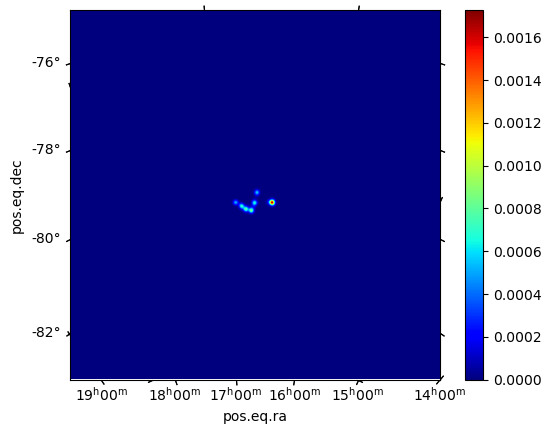

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 250.0  -80.0  1.0  260000000.0  
CRPIX : 1025.0  1025.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0044444444444445  0.0044444444444444  1.0  260000000.0  
NAXIS : 2048  2048  1  1


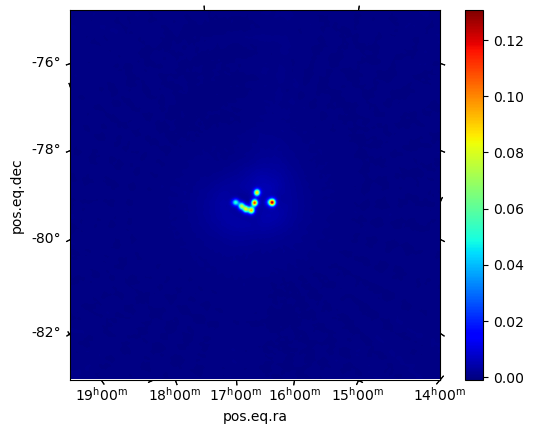

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 250.0  -80.0  1.0  100000000.0  
CRPIX : 1025.0  1025.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0044444444444445  0.0044444444444444  1.0  20000000.0  
NAXIS : 2048  2048  1  16


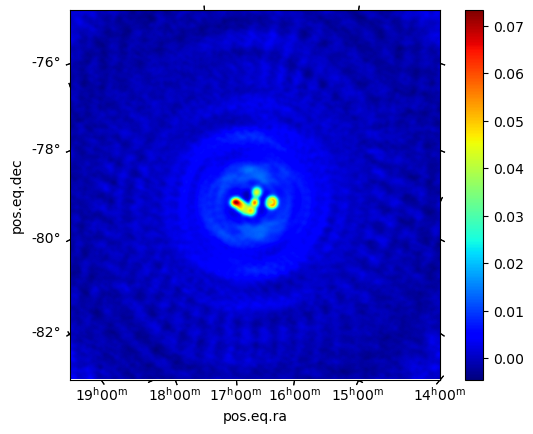

In [14]:
deconvolved, restored, residual = result

deconvolved.plot()
deconvolved.write_to_file("./deconvolved.fits")
restored.plot()
restored.write_to_file("./restored.fits")
residual.plot()
residual.write_to_file("./residual.fits")

### Detect Sources in produced image



In [15]:
detection_result = SourceDetectionResult.detect_sources_in_image(restored)
detection_result.detected_sources

--> Opened '/home/vincenzo/Karabo-Pipeline/karabo/examples/.tmp/31a62bb0-51e5-4f42-a331-45498f9b3375'
Image size .............................. : (2048, 2048) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (5.58324e-02, 5.15437e-02, -24.5) degrees
Frequency of image ...................... : 260.000 MHz
Number of blank pixels .................. : 0 (0.0%)
Flux from sum of (non-blank) pixels ..... : 3.828 Jy
--> Calculating background rms and mean images
Derived rms_box (box size, step size) ... : (2325, 205) pixels
--> Size of rms_box larger than 1/4 of image size
--> Using constant background rms and mean
Value of background rms ................. : 2.46e-04 Jy/beam
Value of background mean ................ : -0.00025 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 55
Number of isl

Fitting islands with Gaussians .......... : [|] 0/1

In [ ]:
mapping = SourceDetectionEvaluation.evaluate_result_with_sky_in_pixel_space(detection_result, filtered_sky, 10)
mapping.plot()